In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (40,40)
import matplotlib
import networkx as nx
import numpy as np
from sklearn import preprocessing
from math import sqrt
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
data = pd.read_csv("book1.csv") # read book1.csv

In [3]:
#label coding result to convert into 0,1
le = preprocessing.LabelEncoder() 
data['result'] = le.fit_transform(data['result'])

In [4]:
data_array = data.to_numpy() # dataframe to array

In [5]:
def euclidean_distance(a, b): # eclidean distance between rows.
    return distance.euclidean(a, b)

def neighbour_list(data, row, num_neighbors):
    distances_list = list()
    for i in range(len(data)):
        dist = euclidean_distance(row, data[i])
        distances_list.append((data[i], dist,i)) # lsit of [data, distance,index] of row 
    distances_list.sort(key=lambda tup: tup[1]) # sorting the list of list
    neighbors_list = list()
    for i in range(num_neighbors):
        neighbors_list.append([distances_list[i][2],distances_list[i][0][-1]]) # list of [index,pass or fail value as 0 or 1]
    return neighbors_list


def plot_graph(data_array,k):
    g = nx.DiGraph() # initializing graph
    g.add_nodes_from(range(len(data_array))) # creating nodes to pick from for graph.
    fail = []
    pass1 = []
    for i in range(len(data_array)):
        neighbors = neighbour_list(data_array, data_array[i], k)
        for neighbor in range(1,len(neighbors)): # iterating over function 
            #print(i,neighbors[neighbor])
            if neighbors[neighbor][1] == 0: # 0 means its fails so the data point or node will get append into fail list.
                if not (((i,neighbors[neighbor][0]) in fail) or ((neighbors[neighbor][0],i) in fail)):
                    fail.append((i,neighbors[neighbor][0]))
            else: # 1 means its pass so the data point or node will get append into pass1 list.
                if not (((i,neighbors[neighbor][0]) in pass1) and ((neighbors[neighbor][0],i) in pass1)):
                    pass1.append((i,neighbors[neighbor][0]))
            g.add_edge(i,neighbors[neighbor][0]) # add edge

    pos = nx.spring_layout(g)
    nx.draw_networkx_labels(g, pos) # labels
    nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'),node_size = 300)
    nx.draw_networkx_edges(g, pos, edgelist=fail, edge_color='r', arrows=False) # for fail
    nx.draw_networkx_edges(g, pos, edgelist=pass1, edge_color='g', arrows=False) # for pass
    plt.draw()
    plt.savefig('graph.jpg', bbox_inches='tight')
    plt.show()

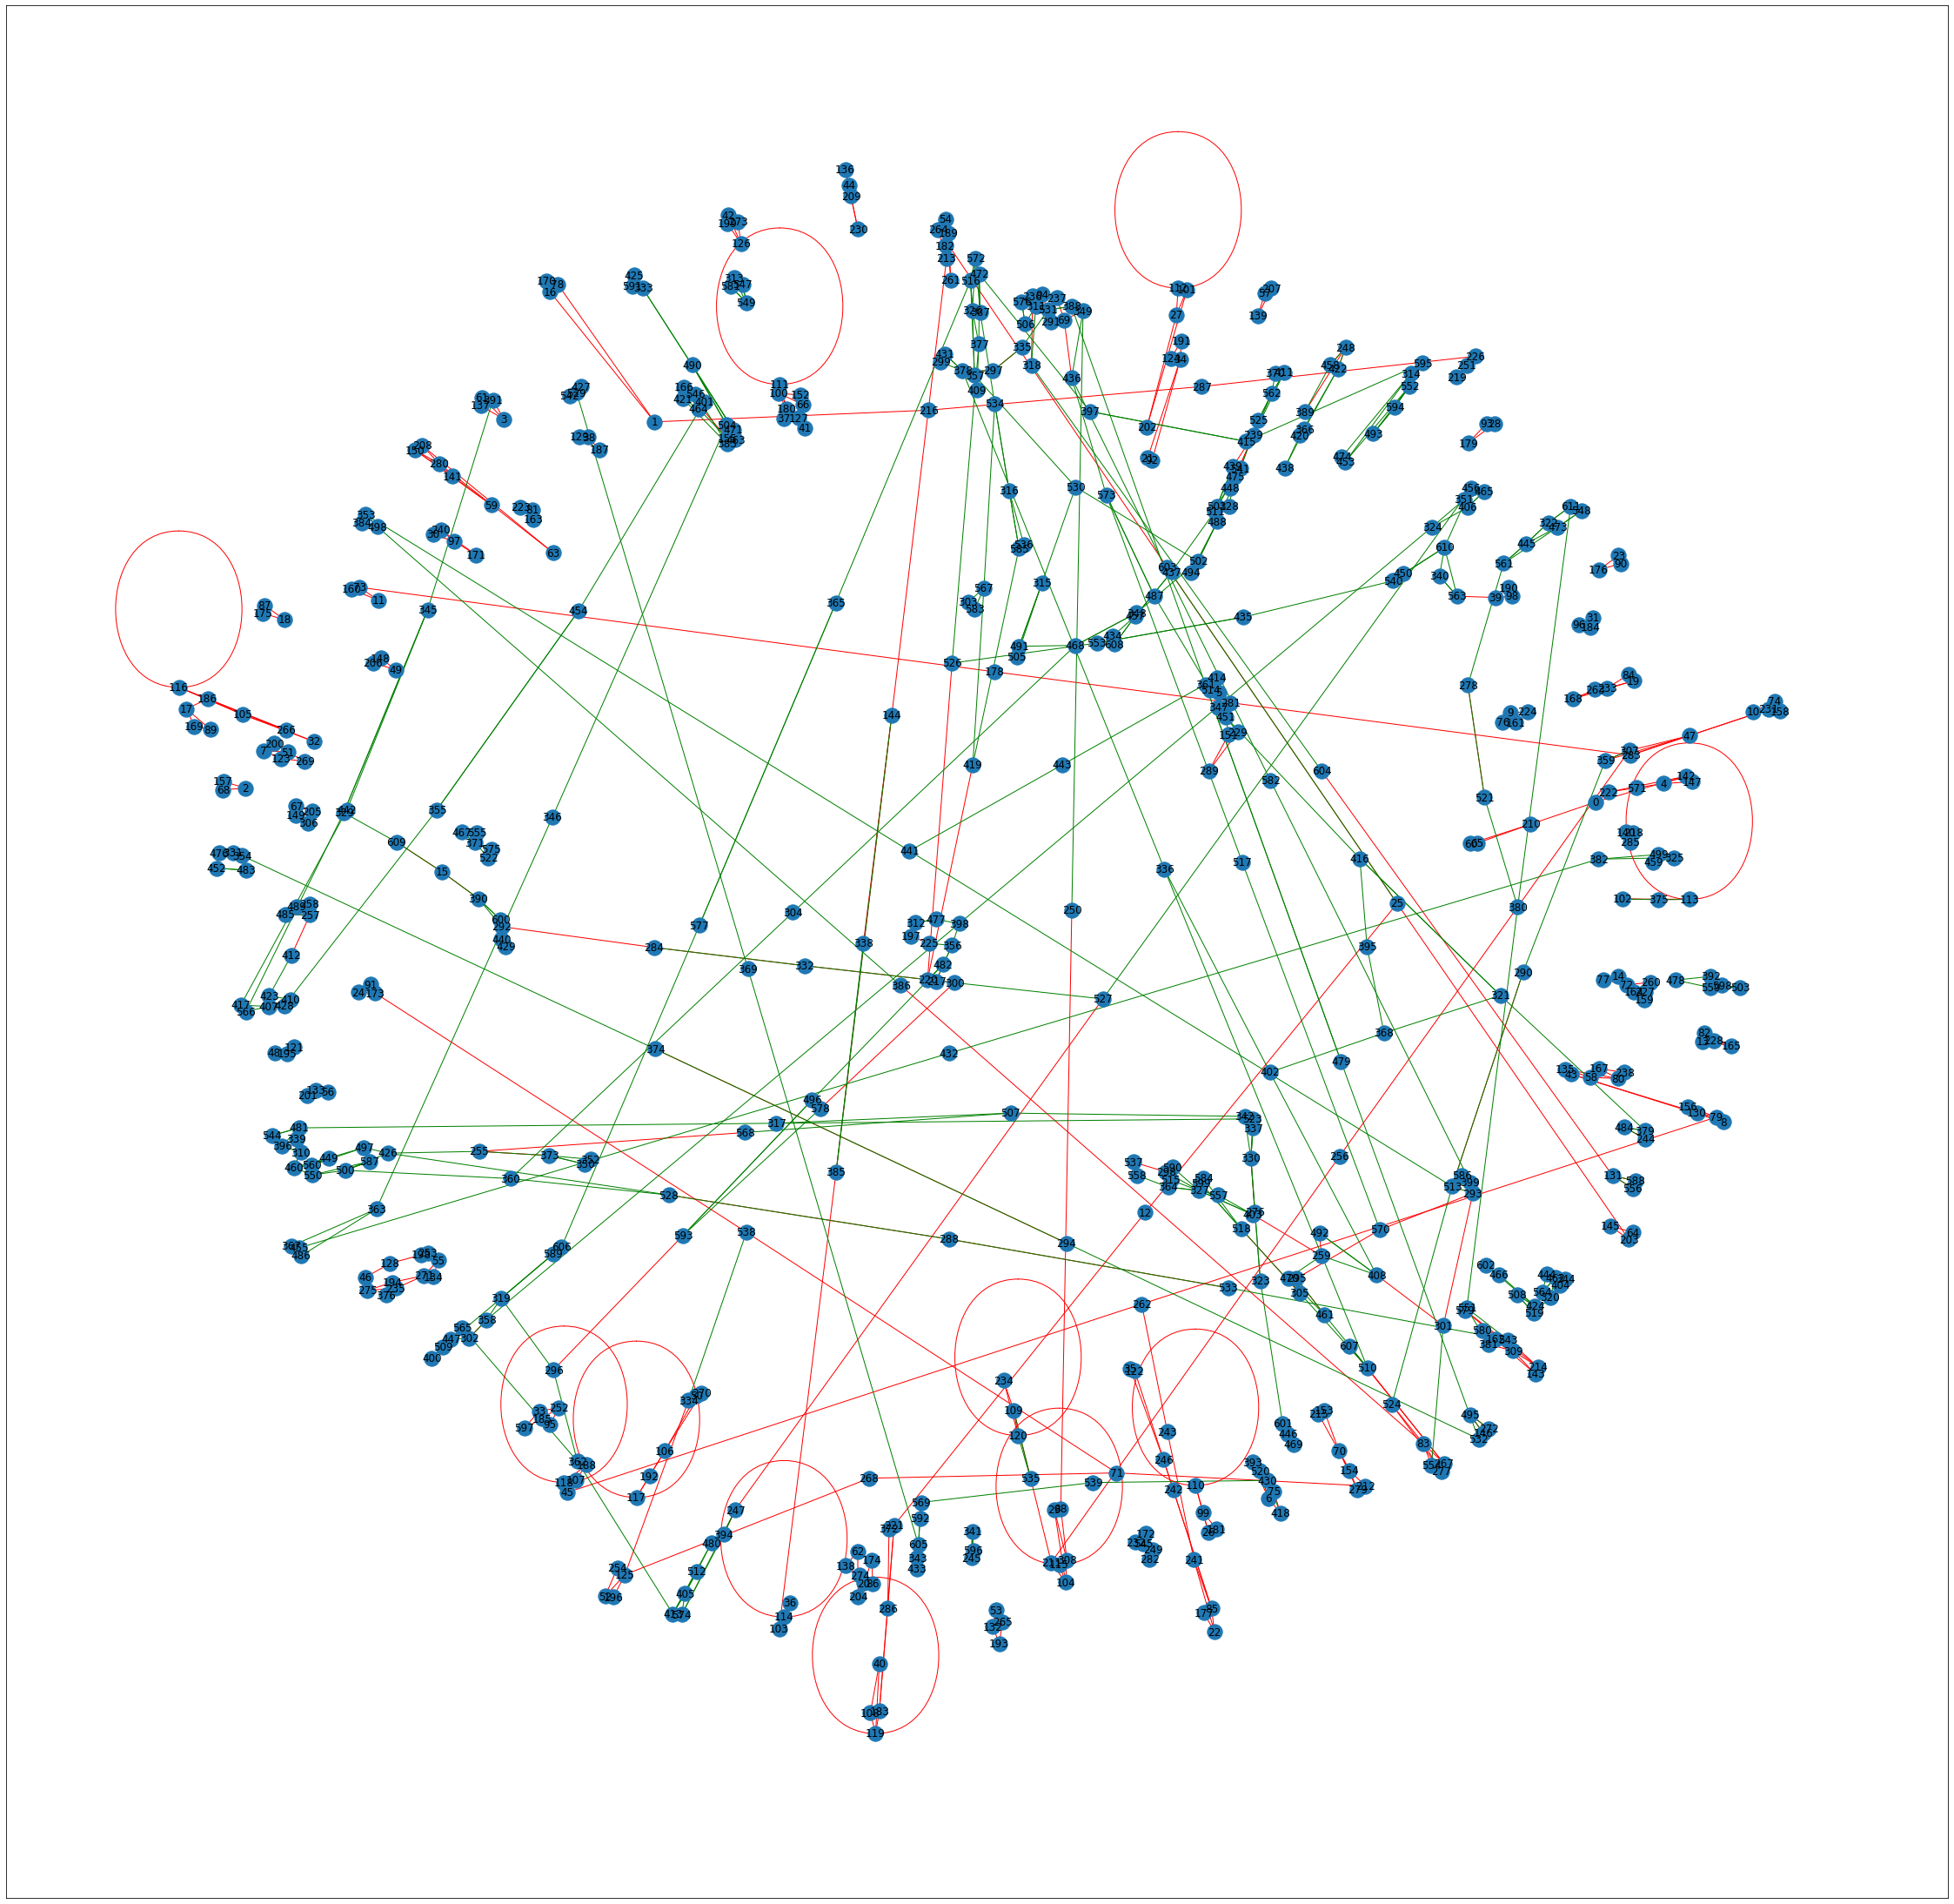

In [6]:
plot_graph(data_array,3)

In [7]:
pca = PCA(n_components=2) # pca of two components

In [8]:
principalComponents  = pca.fit_transform(data.drop(['result'],1))

<ipython-input-8-3335b04c386b>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  principalComponents  = pca.fit_transform(data.drop(['result'],1))


In [9]:
pca_df = pd.DataFrame(principalComponents,columns = ['PCA1','PCA2'])
pca_df['result'] = data['result']

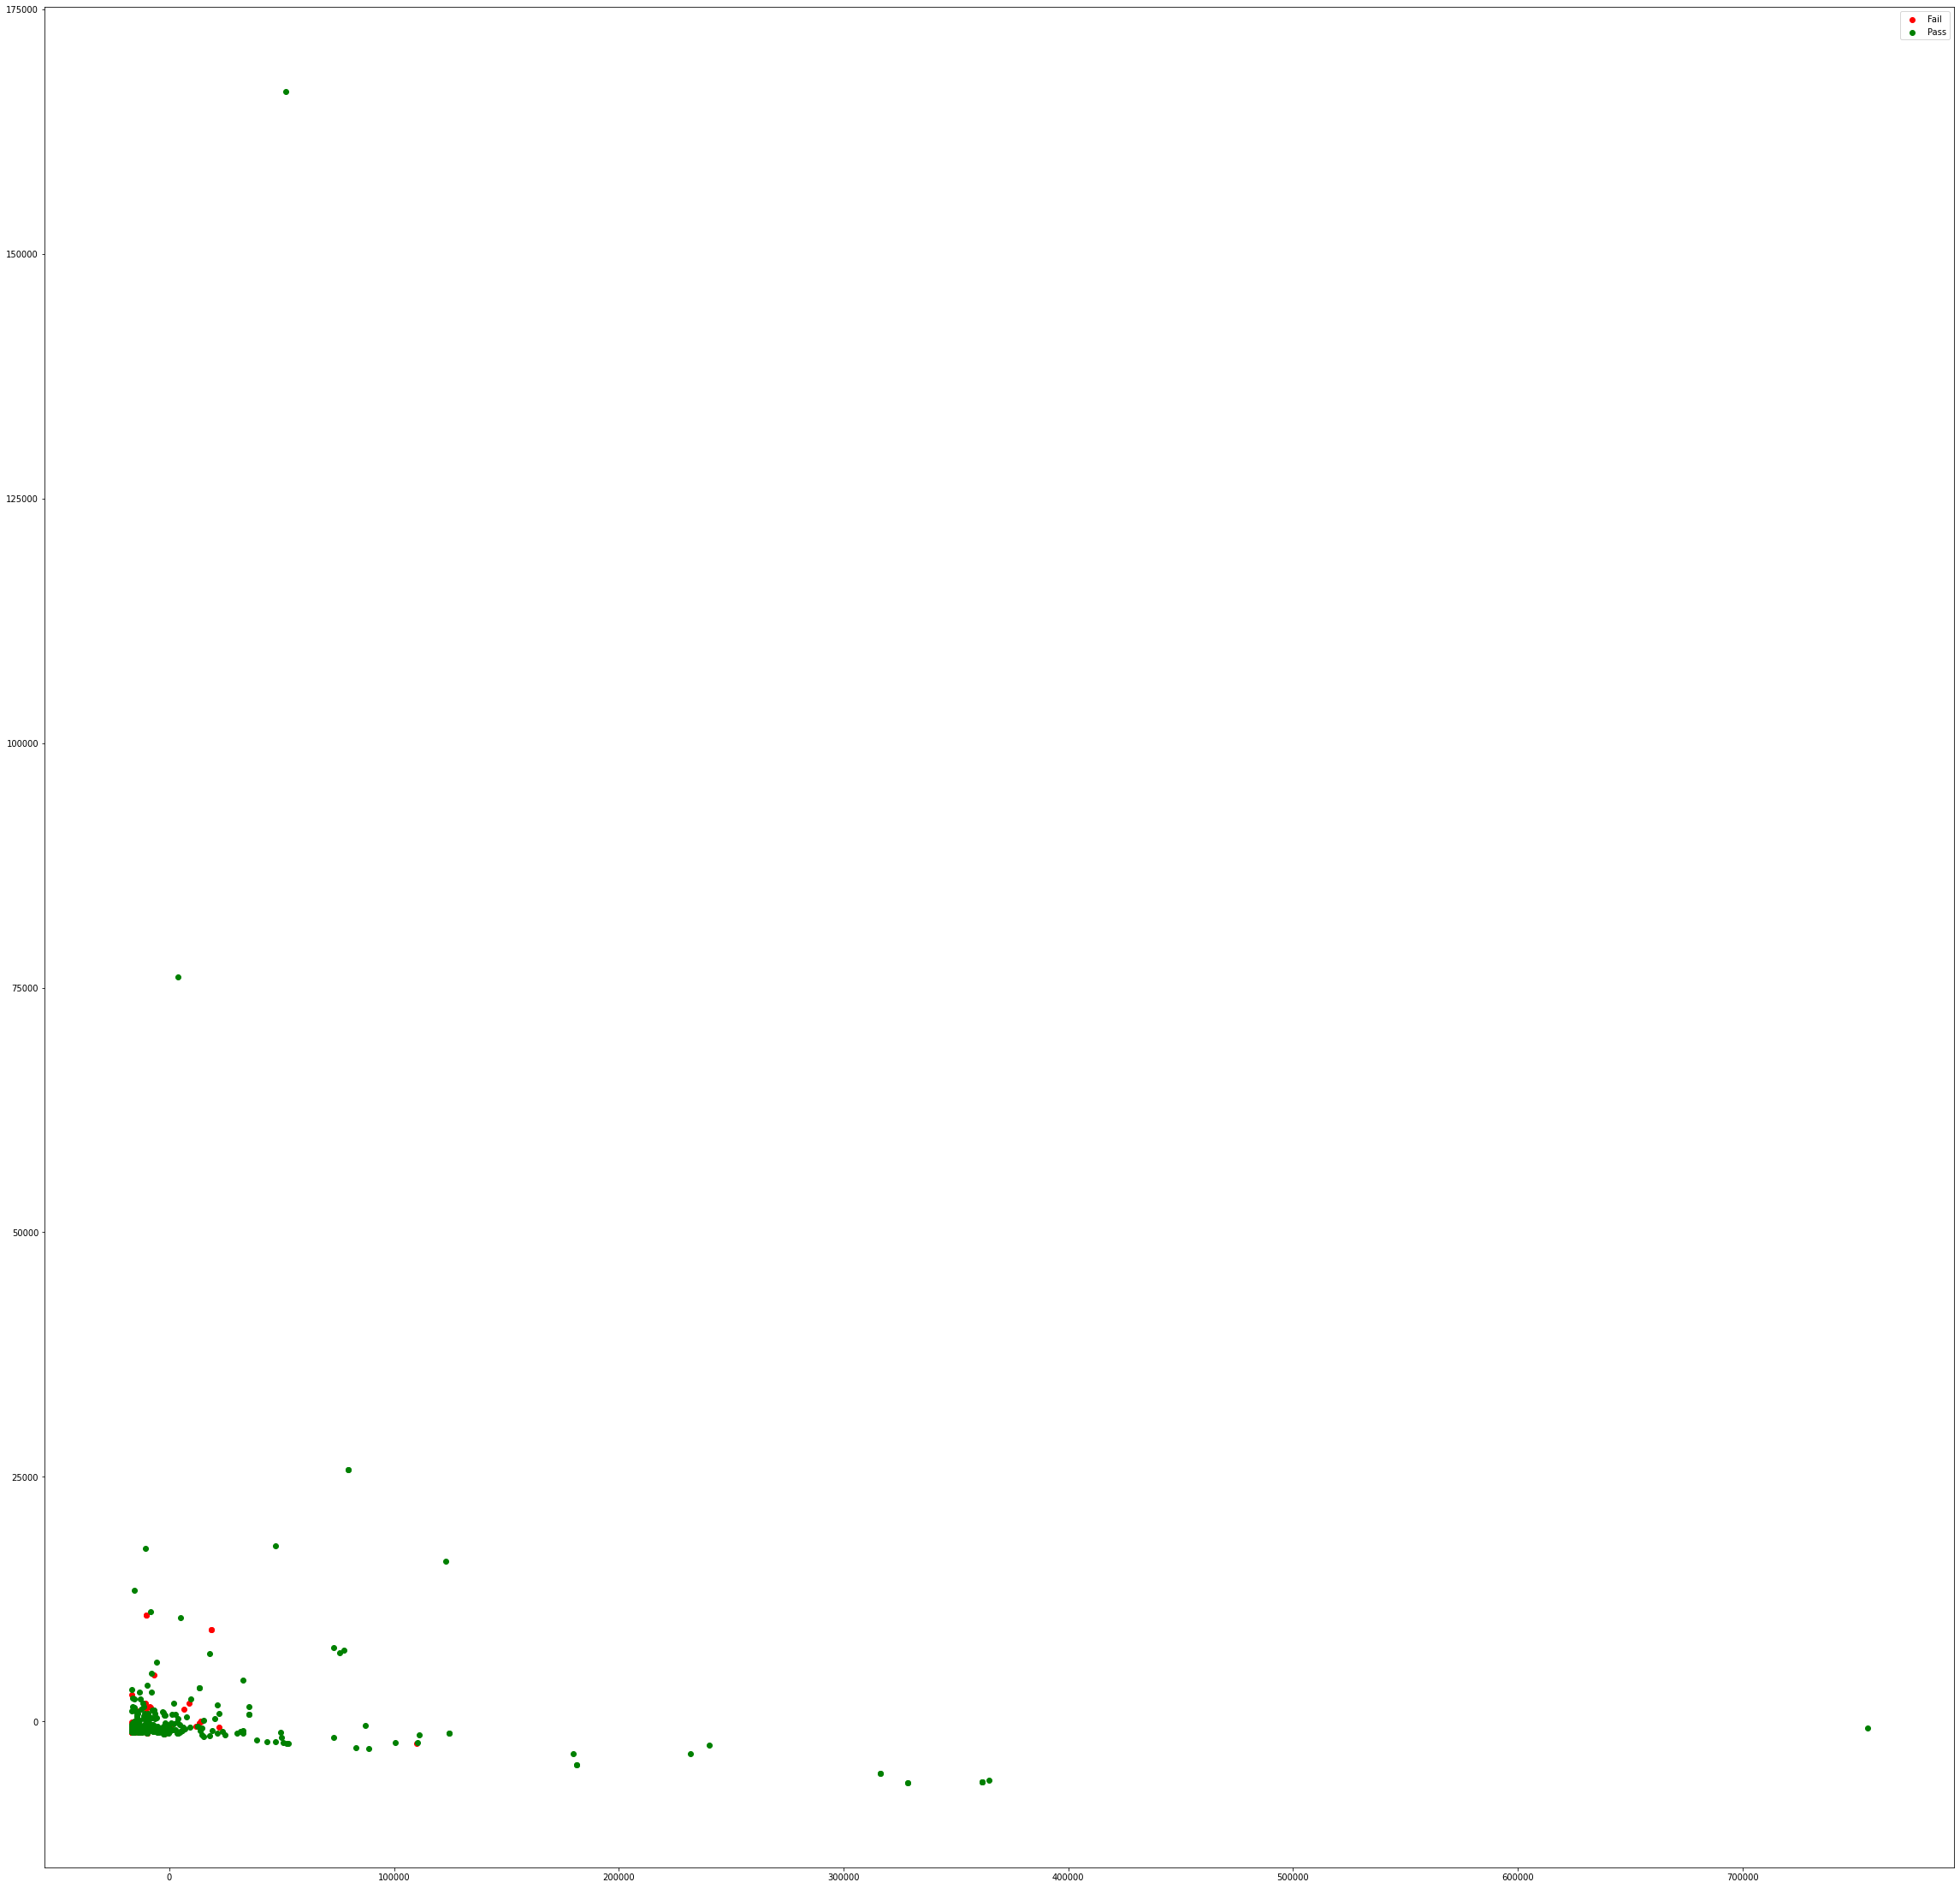

In [10]:
fig, ax = plt.subplots()
la = ['Fail','Pass']
cl = ['red', 'green']
for i in range(len(cl)):
    ax.scatter(pca_df[pca_df['result']== i]['PCA1'], pca_df[pca_df['result']== i]['PCA2'], c=cl[i], label=la[i])
ax.legend()
plt.show()

In [11]:
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
#https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python

In [12]:
X = data.drop(columns=['result'])
y = data['result']

In [13]:
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(X)

NearestNeighbors(n_neighbors=3)

In [14]:
A = neigh.kneighbors_graph(X)
A = A.toarray()
A.shape

(612, 612)

In [15]:
A_df = pd.DataFrame(A)
A_df['result'] = y

In [16]:
#pip install scipy==1.8.0

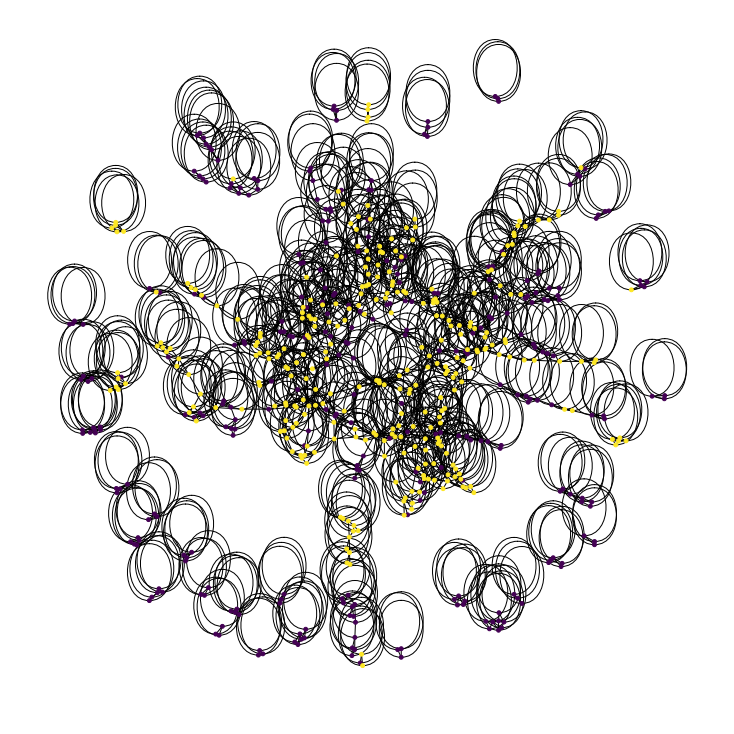

In [17]:
plt.figure(figsize=(10, 10))
colors = A_df["result"].tolist()
cora_graph = nx.from_pandas_adjacency(A_df)
nx.draw_spring(cora_graph, node_size=15, node_color=list(y))

In [18]:
train_data, test_data = [], []

for _, group_data in A_df.groupby("result"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.75
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (455, 613)
Test data shape: (157, 613)


In [19]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [20]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [21]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [22]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
feature_names = set(A_df.columns)

In [24]:
num_features = len(feature_names)
num_classes = 2

In [25]:
num_features,num_classes

(613, 2)

In [26]:
# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["result"]
y_test = test_data["result"]

In [27]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 613)]        0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           23284       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [28]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
2/2 [==============================] - 4s 481ms/step - loss: 2.6740 - acc: 0.4637 - val_loss: 0.7556 - val_acc: 0.5217
Epoch 2/300
2/2 [==============================] - 0s 47ms/step - loss: 1.3654 - acc: 0.5466 - val_loss: 0.7947 - val_acc: 0.5217
Epoch 3/300
2/2 [==============================] - 0s 47ms/step - loss: 1.6484 - acc: 0.5207 - val_loss: 0.7308 - val_acc: 0.5217
Epoch 4/300
2/2 [==============================] - 0s 33ms/step - loss: 1.4712 - acc: 0.4948 - val_loss: 0.6837 - val_acc: 0.5217
Epoch 5/300
2/2 [==============================] - 0s 34ms/step - loss: 1.0889 - acc: 0.5440 - val_loss: 0.6635 - val_acc: 0.5217
Epoch 6/300
2/2 [==============================] - 0s 40ms/step - loss: 0.9895 - acc: 0.5881 - val_loss: 0.6568 - val_acc: 0.5217
Epoch 7/300
2/2 [==============================] - 0s 29ms/step - loss: 0.9315 - acc: 0.5881 - val_loss: 0.6622 - val_acc: 0.5217
Epoch 8/300
2/2 [==============================] - 0s 38ms/step - loss: 0.7918 - acc: 0.6

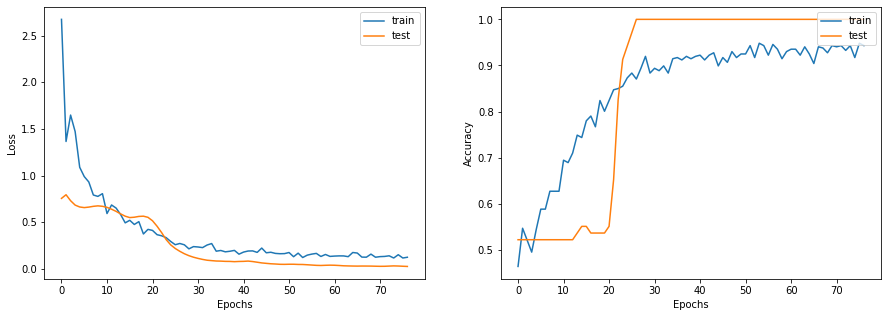

In [29]:
display_learning_curves(history)

In [30]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 99.36%
